(Temporary) upload file in Colab then specify path and filename

In [ ]:
!mkdir input
!mkdir output

url, filename = ("/content/input/gibsonst.jpg", "gibsonst.jpg") # IMAGE MUST BE JPG

mkdir: cannot create directory ‘input’: File exists
mkdir: cannot create directory ‘output’: File exists


# Setup

In [ ]:
!pip install timm

In [ ]:
import cv2
import torch
import urllib.request
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)

Move model to GPU

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  midas = torch.hub.load("intel-isl/MiDaS", model_type)
  midas.to(device)
  midas.eval()
else:
  raise Exception("GPU not found.")

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load transforms to resize and normalize the image for large or small model

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

(-0.5, 957.5, 436.5, -0.5)

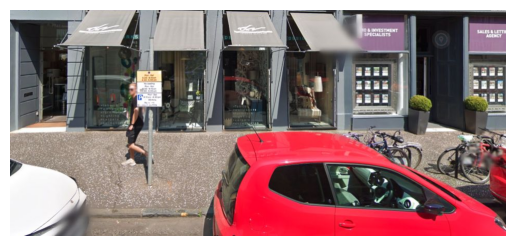

In [ ]:
img = cv2.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Image as a numpy ndarray
input_batch = transform(img).to(device)
plt.imshow(img)
plt.axis('off')

Predict depths and resize to original resolution

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show depth prediction

(437, 958)

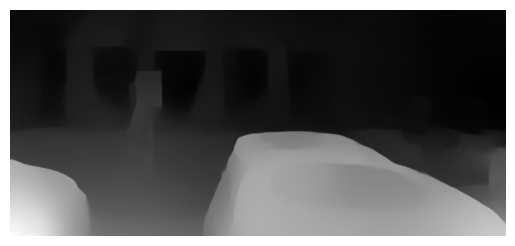

In [ ]:
plt.imshow(output, cmap='gray')
plt.axis('off')
output.shape

# Image segmentation
Set up image segmentation

In [ ]:
!pip install transformers
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from matplotlib import cm

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

Predict image segments

In [ ]:
img_pil = Image.open(url)

inputs = processor(img_pil, return_tensors='pt')

with torch.no_grad():
  outputs = model(**inputs)

prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[img_pil.size[::-1]])[0]

`label_ids_to_fuse` unset. No instance will be fused.


Display image segments

<ipython-input-12-48b15c2a5c09>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


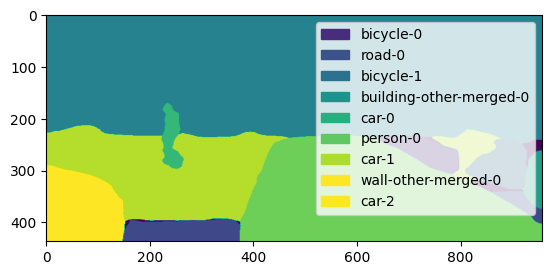

In [ ]:
from collections import defaultdict
import matplotlib.patches as mpatches

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    ax.legend(handles=handles)
draw_panoptic_segmentation(prediction['segmentation'], prediction['segments_info'])

Take each segment and create a mask

In [ ]:
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Mask2Former/Inference_with_Mask2Former.ipynb

def get_mask(segment_id):
  mask = (prediction['segmentation'].numpy() == segment_id)
  mask = (mask * 255).astype(np.uint8)
  return mask

In [ ]:
"""
def get_depth(mask):
  mask_pil = Image.fromarray(mask)
  mask_pil = mask_pil.convert('RGB')
  mask_pil = mask_pil.convert('L')
  depth = np.median(output[np.array(mask_pil)]) # To solve - better average depth calculation
  return depth

"""
def get_depth(mask):
  return np.median(output[np.array(mask)])

Get the width of each segment to decide whether or not its a background image

In [ ]:
"""
def get_width(mask):
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  total_w = 0
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    total_w += w

  return(total_w)
"""

"""
mask_info = []
for segment_info in prediction['segments_info']:
  m = get_mask(segment_info['id'])
  if get_width(m) < 0.5*img_pil.width: # 0.5 is an arbitrary number, decide what number to use
    mask_info.append([m, get_depth(m)])
"""

"""
  This method is not effective, the car would be too large
  We can try naming objects instead however may not be as robust

  May need to research foreground detection
"""

'\n  This method is not effective, the car would be too large\n  We can try naming objects instead however may not be as robust\n\n  May need to research foreground detection\n'

Populate a list with key details of mask

In [ ]:
def populate_mask_info():
  mask_info = []
  background_objects = ['wall', 'road', 'building']

  depths = np.array([])
  for segment_info in prediction['segments_info']:
    label = model.config.id2label[segment_info['label_id']].split('-')[0] # get the first word of the label
    if label not in background_objects:
      m = get_mask(segment_info['id'])
      d = get_depth(m)
      depths = np.append(depths, d)
      mask_info.append([m, d, label])
  return mask_info

mask_info = populate_mask_info()

In [ ]:
def display_images(images, size=(100, 20)):
  fig, axes = plt.subplots(1, len(images), figsize=size)

  # Iterate through the images and display them
  for i, plane in enumerate(images):
      axes[i].imshow(plane)
      axes[i].axis('off')

  plt.show()

Sort the list by depth ascending

In [ ]:
mask_info = sorted(mask_info, key=lambda x: x[1])
print("Median depths of segments in ascending order")
for mask in mask_info:
  print(mask[1], mask[2])

# Get the depths
#plt.imshow(mask_info[6][0])

Median depths of segments in ascending order
4.7242565 car
4.7242565 person
4.726053 bicycle
4.7299795 bicycle
4.7623496 car
5.1762166 car


Classify depths into different levels

In [ ]:
# Redundant for now as depth calculations not as expected
"""
def remove_duplicate_depths(depths, threshold=0.0065):
  unique = [mask_info[0][1]]
  for depth in depths[1:]:
    for u_depth in unique:
      if abs(depth - u_depth) < threshold:
        break
      else:
        unique.append(depth)
        break
  return unique

print(remove_duplicate_depths(depths))

def reassign_unique_depths():
  unique_depths = remove_duplicate_depths(depths)
  for mask in mask_info:
    mask[1] = unique_depths[np.argmin([abs([mask[1]] - u_depth) for u_depth in unique_depths])]
    print(mask[1], mask[2])

  return mask_info

mask_info = reassign_unique_depths()
"""

'\ndef remove_duplicate_depths(depths, threshold=0.0065):\n  unique = [mask_info[0][1]]\n  for depth in depths[1:]:\n    for u_depth in unique:\n      if abs(depth - u_depth) < threshold:\n        break\n      else:\n        unique.append(depth)\n        break\n  return unique\n\nprint(remove_duplicate_depths(depths))\n\ndef reassign_unique_depths():\n  unique_depths = remove_duplicate_depths(depths)\n  for mask in mask_info:\n    mask[1] = unique_depths[np.argmin([abs([mask[1]] - u_depth) for u_depth in unique_depths])]\n    print(mask[1], mask[2])\n\n  return mask_info\n\nmask_info = reassign_unique_depths()\n'

Display the masks and calculate the depths at which to chop the images into

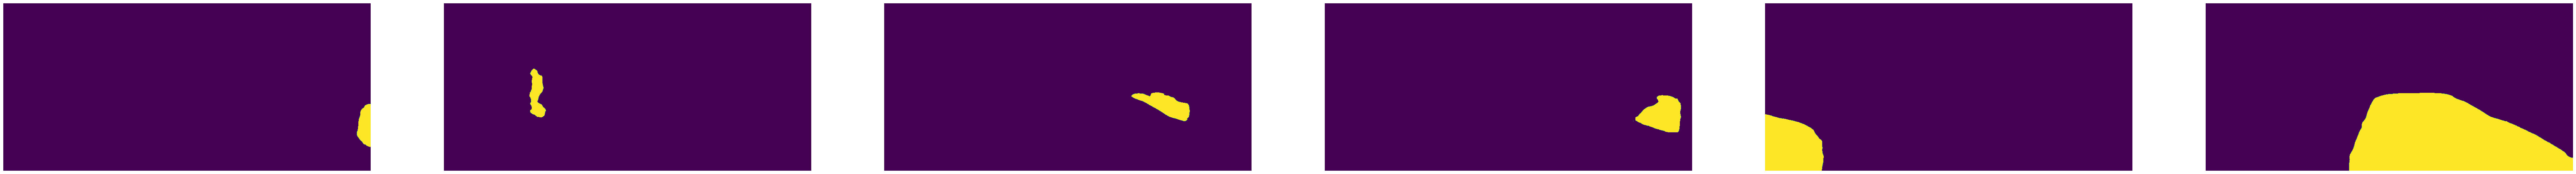

In [ ]:
if len(mask_info) > 1:
  display_images([mask[0] for mask in mask_info])
  depth_ranges = [[mask_info[i][1], mask_info[i+1][1]] for i in range(len(mask_info)-1)]
else:
  plt.imshow(mask_info[0][0])
  depth_ranges = 0

Chop the image into different depth levels

In [ ]:
def get_depth_planes(depth_ranges):
  if depth_ranges == 0: # Case where there is only a single foreground object
    mask_reshape = np.stack((mask_info[0][0], mask_info[0][0], mask_info[0][0]), axis=-1)
    return np.where(mask_reshape, img, mask_reshape)
  else:
    depth_planes = []
    for (a,b) in depth_ranges:
      for mask in mask_info:
        if a <= mask[1] <= b:
          mask_reshape = np.stack((mask[0], mask[0], mask[0]), axis=-1)
          depth_planes.append(np.where(mask_reshape, img, mask_reshape))
    print("There are " + str(len(depth_planes)) + " depth planes" )
    depth_planes.reverse()
    return depth_planes



(Temporary solution) remove duplicate planes

In [ ]:
def get_unique_planes(depth_planes):
  unique_planes = []

  for plane in depth_planes:
    if not any(np.array_equal(plane, unique) for unique in unique_planes):
      unique_planes.append(plane)
  print(str(len(unique_planes)) + " unique depth planes")
  return unique_planes

Display the different depth planes

There are 11 depth planes
6 unique depth planes


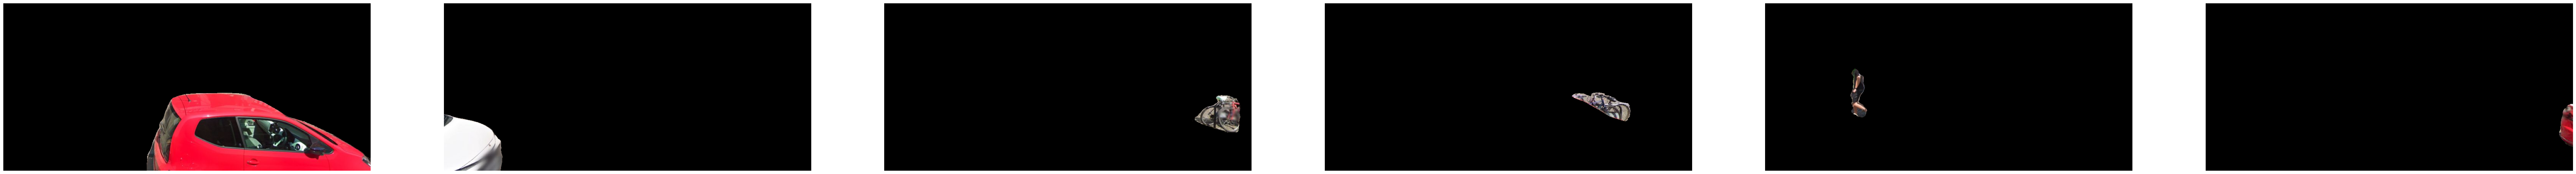

In [ ]:
depth_planes = get_depth_planes(depth_ranges)
if len(mask_info) > 1:
  depth_planes = get_unique_planes(depth_planes)
  display_images(depth_planes)
else:
  plt.imshow(depth_planes)

In [ ]:
!pip install -qq -U diffusers==0.11.1 transformers ftfy gradio accelerate

In [ ]:
import inspect
from typing import List, Optional, Union

import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
).to(device)

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

safety_checker/model.safetensors not found


Fetching 24 files:   0%|          | 0/24 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

pytorch_model.fp16.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


Caption the image

In [ ]:
!pip install ultralytics
!pip install Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 660.5/660.5 kB 10.9 MB/s eta 0:00:00


In [ ]:
import tqdm
import ultralytics
import os

In [ ]:
!git clone https://github.com/JoeL-8883/attention-object-based-captioning

Cloning into 'attention-object-based-captioning'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 44 (delta 0), reused 1 (delta 0), pack-reused 41
Receiving objects: 100% (44/44), 104.62 MiB | 6.97 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (30/30), done.


In [ ]:
import os
import pandas as pd

ModuleNotFoundError: ignored

Remove the object in mind for captioning

Possible fix to code below, run python scripts then run the code below????

In [ ]:
"""
This script is used to run inference. It will load the model and the tokenizer and then generate captions in the folder
specified by the user. The user can specify the number of captions to generate for each image.
"""

from src.models.captioner import ImageCaptioningModel
from src.utils.data_utils import DataUtils

# ====================================== PARAMETERS ====================================== #

# path to the folder containing the images
images_folder_path = '/content/input'

# output folder name
# The captions will be saved in csv format in the folder specified by the user
output_folder_name = '/content/output'

# dimensions that the images will be resized to before feeding them to the model
# Make sure they match the dimensions used to train the model
# If you're using the pretrained model, leave as is
image_dimensions = (192, 192)

# preprocessing function to use
# Make sure it matches the preprocessing function used to train the model
preprocess_function = tf.keras.applications.xception.preprocess_input

# path to the folder containing the submodels
# Make sure that it contains the following files and folders:
# - tokenizer_wrapper.pkl: Wrapper object for the tokenizer and the max_length
# - encoder/: Folder containing the encoder model
# - decoder/: Folder containing the decoder model
# - attention/: Folder containing the attention model
models_path = '/content/attention-object-based-captioning/saved_models'


if __name__ == '__main__':

    # load the model
    model = ImageCaptioningModel.load_model(models_path)

    # load the data
    data_dic = DataUtils.load_inference_data(
        image_dimensions=image_dimensions,
        images_folder_path=images_folder_path,
        preprocess_function=preprocess_function
    )

    # unpack the data
    images_dic = data_dic['images_dic']
    importance_features_dic = data_dic['importance_features_dic']

    # create the output dataframe
    output_df = pd.DataFrame(columns=['image', 'caption'])

    # generate the captions
    print('Generating captions...')
    for filename in (images_dic.keys()):

        # expand the dimensions of the image and importance features
        image = tf.expand_dims(images_dic[filename], axis=0)
        importance_features = tf.expand_dims(
            importance_features_dic[filename], axis=0)

        # generate the captions
        caption = model((image, importance_features))

        caption = " ".join(caption[0])

        # add the caption to the dataframe
        output_df = pd.concat([output_df, pd.DataFrame(
            [[filename, caption]], columns=['image', 'caption'])])

    # save the dataframe
    output_df.to_csv(os.path.join(output_folder_name, 'results.csv'),
                     index=False)
    print('Captions saved in {}'.format(
        os.path.join(output_folder_name, 'results.csv')))


Loading the models...


Models loaded!
Loading the tokenizer and the max_length...
Constructing the captioner...
Captioner loaded successfully!


Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'Pillow>=10.0.1'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 51.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 164.5 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 12.8s, installed 2 packages: ['gitpython>=3.1.30', 'Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2023-12-13 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 236MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Reading 1 images sequentially...


100%|██████████| 1/1 [00:00<00:00, 49.24it/s]


Extracting importance features...


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Preprocessing images...


100%|██████████| 1/1 [00:00<00:00, 168.83it/s]


Generating captions...
Captions saved in /content/output/results.csv


Perform inpainting at different depth levels

In [ ]:
def generate_prompt(mask):
  return "Remove object"

In [ ]:
prompt = 0 # change to automatically generated prompt

guidance_scale = 7.5
num_samples = 1
generator = torch.Generator(device="cuda").manual_seed(0)
inpaint_target = img_pil.resize((512,512))
inpainted_images = [inpaint_target]


# Iterate through each depth level
for mask in mask_info:
  prompt = generate_prompt(mask[0])
  print("Prompt", prompt)
  print(mask[2])
  # Inpaint
  inpainted = pipe(
    prompt=prompt,
    image=inpaint_target,
    mask_image=Image.fromarray(mask[0]).resize((512,512)),
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
  ).images

  inpainted_images.append(inpainted[0])
  inpaint_target = inpainted[0]
display_images(inpainted_images)




Prompt Remove object
car


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt Remove object
person


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt Remove object
bicycle


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt Remove object
bicycle


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt Remove object
car


  0%|          | 0/50 [00:00<?, ?it/s]

Prompt Remove object
car


  0%|          | 0/50 [00:00<?, ?it/s]

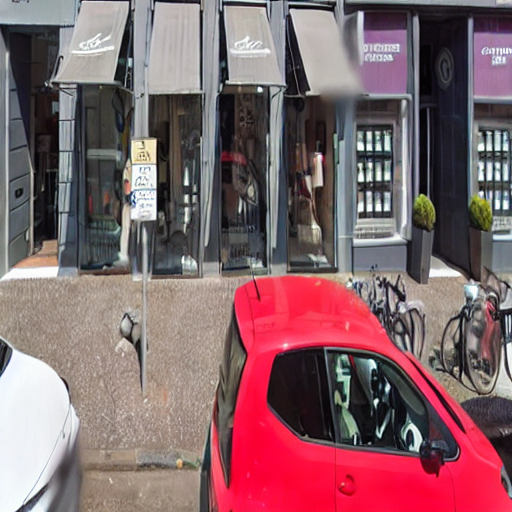

In [ ]:
display(inpainted_images[1])

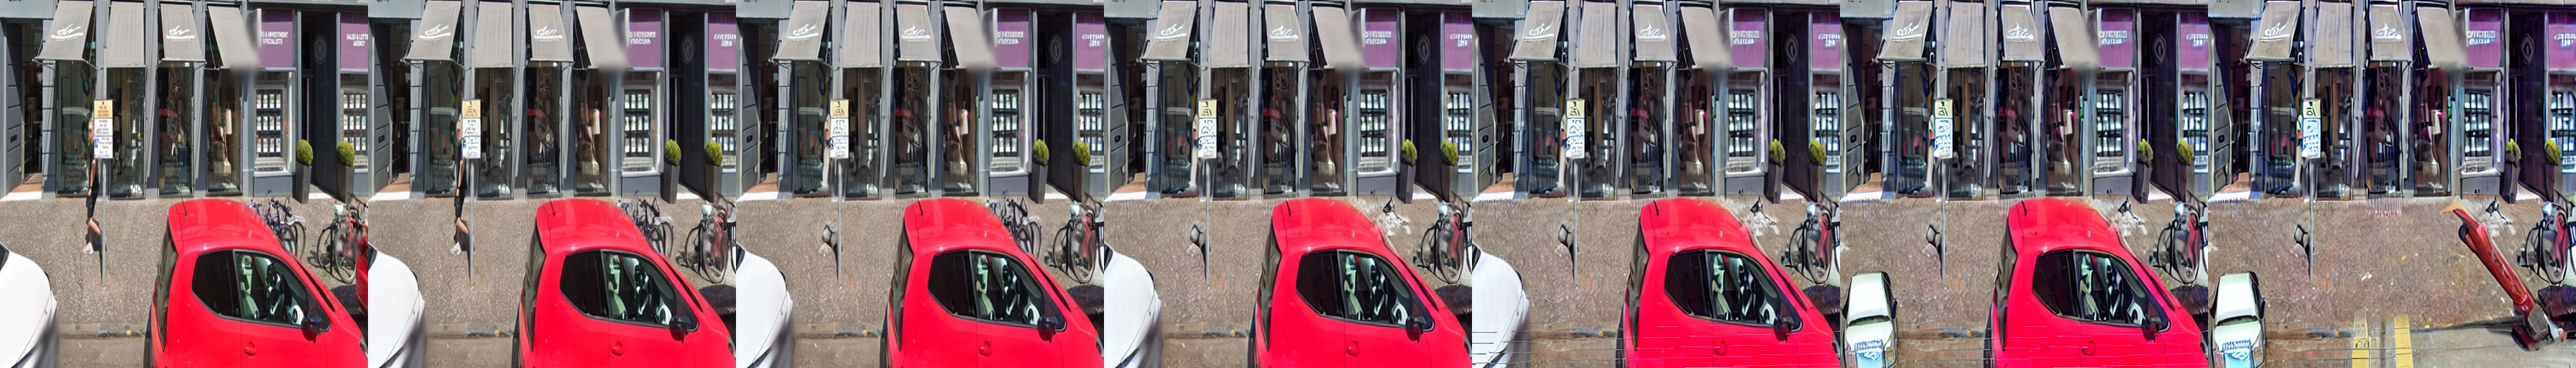

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

image_grid(inpainted_images, 1, len(inpainted_images))

In [ ]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

SyntaxError: ignored

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}